# Based on: ["Working with missing data"](https://pandas.pydata.org/pandas-docs/stable/user_guide/missing_data.html)

In [1]:
import pandas as pd
import numpy as np

# 1. Values considered "missing"

`NaN` is the default missing value marker. In many cases, Python's `None` will also be considered "missing" or "not available" (`NA`).

To consider `inf` and `-inf` as `NA` in computations, set:

```python
pandas.options.mode.use_inf_as_na = True.
```

*pandas* provides the [isna()][isna] and [notna()][notna] functions/methods to help detect missing values.

>**NOTE:** `nan`'s don’t compare equal, but `None`'s do.


[isna]: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.isna.html#pandas.isna
[notna]: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.notna.html#pandas.notna

In [2]:
df = pd.DataFrame(
    {
        "A": range(5),
        "B": list("abc") + [np.nan, None],
        "C": [float("inf"), float("-inf"), np.inf, -np.inf, 0],
    }
)
df.head()

,A,B,C
0,0,a,inf
1,1,b,-inf
2,2,c,inf
3,3,NaN,-inf
4,4,None,0.0


In [3]:
pd.options.mode.use_inf_as_na = True

df.head()

,A,B,C
0,0,a,NaN
1,1,b,NaN
2,2,c,NaN
3,3,NaN,NaN
4,4,None,0.0


In [4]:
df.isna()

,A,B,C
0,False,False,True
1,False,False,True
2,False,False,True
3,False,True,True
4,False,True,False


In [5]:
df.loc[3, "B"] == np.nan

False

In [6]:
df.loc[4, "B"] == None

True

## 1.1 Integer dtypes and missing data

Because `NaN` is a `float`, a column of integers with *even one missing value* is cast to floating-point dtype.

*pandas* provides a *nullable-integer extension dtypes* `Int8Dtype`, `Int16Dtype`, `Int32Dtype` and `Int64Dtype`. See [Support for integer NA](https://pandas.pydata.org/pandas-docs/stable/user_guide/gotchas.html#support-for-integer-na)

In [7]:
s = pd.Series([1, 3, 7, None])
s.dtype

dtype('float64')

In [8]:
s = pd.Series([1, 3, 7, None], dtype="Int8")
s.dtype

Int8Dtype()

## 1.2 Datetimes

`NaT` represents missing values in datetime64[ns] types. *pandas* objects provide compatibility between `NaT` and `NaN`.

In [9]:
s = pd.Series([pd.Timestamp("2021-11-15"), None, np.nan])
s

0   2021-11-15
1          NaT
2          NaT
dtype: datetime64[ns]

In [10]:
s.isna()

0    False
1     True
2     True
dtype: bool

# 2. Inserting missing data

You can insert missing values by simply assigning to containers.

The actual missing value used will be chosen based on the dtype:

- *numeric* containers will always use `NaN` regardless of the missing value type chosen
- *datetime* containers will always use `NaT`
- *object* containers will use the value given

In [11]:
s = pd.Series(range(5))
s.loc[2] = None
s

0    0.0
1    1.0
2    NaN
3    3.0
4    4.0
dtype: float64

In [12]:
s = pd.Series(pd.date_range("2021-11-15", periods=4, freq="D"))
s.loc[1] = None
s

0   2021-11-15
1          NaT
2   2021-11-17
3   2021-11-18
dtype: datetime64[ns]

In [13]:
s = pd.Series(list("wxyz"))
s.loc[1] = None
s

0       w
1    None
2       y
3       z
dtype: object

# 3. Calculations with missing data

Missing values *propagate naturally* through arithmetic operations between *pandas* objects.

The descriptive statistics and computational methods are all written to *account for missing values* by assigining zero or ignoring them.

In [14]:
s = pd.Series([1, 4, None, 16])
s.cumsum()

0     1.0
1     5.0
2     NaN
3    21.0
dtype: float64

In [15]:
s.cumsum(skipna=False)

0    1.0
1    5.0
2    NaN
3    NaN
dtype: float64

# 4. Sum/prod of empties/nans

The sum of an empty or all-NA Series or column of a DataFrame is 0.

The product of an empty or all-NA Series or column of a DataFrame is 1.

In [16]:
s = pd.Series([None] * 5)
s.sum()

0

In [17]:
s.prod()

1

# 5. NA values in GroupBy

`NA` groups in *GroupBy* are *automatically excluded*.

In [18]:
df["D"] = [1, 2, None, 1, 2]
df

,A,B,C,D
0,0,a,NaN,1.0
1,1,b,NaN,2.0
2,2,c,NaN,NaN
3,3,NaN,NaN,1.0
4,4,None,0.0,2.0


In [19]:
df.groupby("D").count()

,A,B,C
D,,,
1.0,2,1,0
2.0,2,1,1


# 6. Filling missing values: `fillna`

[DataFrame.fillna](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.fillna.html#pandas.DataFrame.fillna)

## 6.1 Replace NA with a scalar value

In [20]:
df.fillna("missing")

,A,B,C,D
0,0,a,missing,1.0
1,1,b,missing,2.0
2,2,c,missing,missing
3,3,missing,missing,1.0
4,4,missing,0.0,2.0


## 6.2 Fill gaps forward or backward

In [21]:
df.fillna(method="ffill")

,A,B,C,D
0,0,a,NaN,1.0
1,1,b,NaN,2.0
2,2,c,NaN,2.0
3,3,c,NaN,1.0
4,4,c,0.0,2.0


In [22]:
df.fillna(method="bfill")

,A,B,C,D
0,0,a,0.0,1.0
1,1,b,0.0,2.0
2,2,c,0.0,1.0
3,3,None,0.0,1.0
4,4,None,0.0,2.0


## 6.3 Limit the amount of filling

In [23]:
df.fillna("blank", limit=2)

,A,B,C,D
0,0,a,blank,1.0
1,1,b,blank,2.0
2,2,c,NaN,blank
3,3,blank,NaN,1.0
4,4,blank,0.0,2.0


# 7. Filling with a pandas object

You can *fillna* using a `dict` or `Series` that is alignable. `dict` labels or `Series` index must *match the columns* of the frame you wish to fill. The use case of this is to fill a `DataFrame` with the mean of that column.

In [24]:
dff = pd.DataFrame(np.random.randn(8, 3), columns=list("ABC"))
dff.iloc[3:5, 0] = np.nan
dff.iloc[4:6, 1] = np.nan
dff.iloc[5:8, 2] = np.nan
dff

,A,B,C
0,-0.118785,-1.032320,0.067660
1,0.812766,-0.734080,0.952088
2,0.705292,-1.390157,-1.579813
3,NaN,0.167049,-1.529394
4,NaN,NaN,0.977098
5,-0.239108,NaN,NaN
6,0.437465,-0.030583,NaN
7,0.352536,-1.053035,NaN


In [25]:
dff.fillna(dff.mean()["B":"C"])

,A,B,C
0,-0.118785,-1.032320,0.067660
1,0.812766,-0.734080,0.952088
2,0.705292,-1.390157,-1.579813
3,NaN,0.167049,-1.529394
4,NaN,-0.678854,0.977098
5,-0.239108,-0.678854,-0.222472
6,0.437465,-0.030583,-0.222472
7,0.352536,-1.053035,-0.222472


In [26]:
# Insert mean where value is NaN. Alternative method
dff.where(pd.notna(dff), dff.mean(), axis="columns")

,A,B,C
0,-0.118785,-1.032320,0.067660
1,0.812766,-0.734080,0.952088
2,0.705292,-1.390157,-1.579813
3,0.325028,0.167049,-1.529394
4,0.325028,-0.678854,0.977098
5,-0.239108,-0.678854,-0.222472
6,0.437465,-0.030583,-0.222472
7,0.352536,-1.053035,-0.222472


# 8. Dropping axis labels with missing data: `dropna`

[DataFrame.dropna](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.dropna.html#pandas.DataFrame.dropna)

In [27]:
dff.dropna(axis=0, subset=["A", "B"])

,A,B,C
0,-0.118785,-1.032320,0.067660
1,0.812766,-0.734080,0.952088
2,0.705292,-1.390157,-1.579813
6,0.437465,-0.030583,NaN
7,0.352536,-1.053035,NaN


In [28]:
dff.dropna(axis=1, thresh=6)

,A,B
0,-0.118785,-1.032320
1,0.812766,-0.734080
2,0.705292,-1.390157
3,NaN,0.167049
4,NaN,NaN
5,-0.239108,NaN
6,0.437465,-0.030583
7,0.352536,-1.053035


# 9. Interpolation

[DataFrame.interpolate](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.interpolate.html#pandas.DataFrame.interpolate)

The `method` argument (default, `linear`) gives access to fancier interpolation methods. If you have `scipy` installed, you can pass the name of a *1-d interpolation routine*. See the [scipy interpolation documentation][1] and [reference guide][2] for details.

[1]: https://docs.scipy.org/doc/scipy/reference/interpolate.html#univariate-interpolation
[2]: https://docs.scipy.org/doc/scipy/reference/tutorial/interpolate.html

<AxesSubplot:>

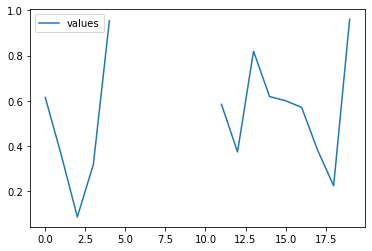

In [29]:
df = pd.DataFrame(np.random.rand(20), columns=["values"])
df.loc[5:10, "values"] = None
df.plot()

array([<AxesSubplot:>, <AxesSubplot:>], dtype=object)

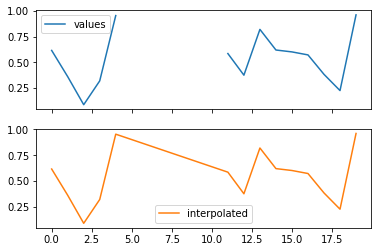

In [30]:
df["interpolated"] = df["values"].interpolate()
df.plot(subplots=True)

array([<AxesSubplot:>, <AxesSubplot:>], dtype=object)

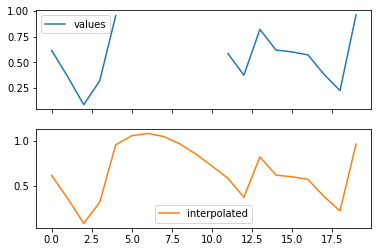

In [31]:
df["interpolated"] = df["values"].interpolate(method="akima")
df.plot(subplots=True)

## 9.1 Interpolation limits

- `limit`: limit the number of consecutive `NaN` values filled since the last valid observation.
- `limit_direction`: specify fill direction ("forward", "backward", "both").
- `limit_area`: specify interval type ("inside", "outside").

In [32]:
ser = pd.Series([np.nan, np.nan, 5, np.nan, np.nan, np.nan, 13, np.nan, np.nan])
ser

0     NaN
1     NaN
2     5.0
3     NaN
4     NaN
5     NaN
6    13.0
7     NaN
8     NaN
dtype: float64

In [33]:
ser.interpolate(limit=2)

0     NaN
1     NaN
2     5.0
3     7.0
4     9.0
5     NaN
6    13.0
7    13.0
8    13.0
dtype: float64

In [34]:
ser.interpolate(limit=1, limit_direction="both", limit_area="outside")

0     NaN
1     5.0
2     5.0
3     NaN
4     NaN
5     NaN
6    13.0
7    13.0
8     NaN
dtype: float64

# 10. Replacing generic values

In [35]:
s = pd.Series([1, 4, 9, 16])
s.replace([1, 9], [2, 8])

0     2
1     4
2     8
3    16
dtype: int64

In [36]:
df = pd.DataFrame({"a": [0, 1, 2, 3, 4], "b": [5, 6, 7, 8, 9]})
df.replace({"a": 0, "b": 5}, 50)

,a,b
0,50,50
1,1,6
2,2,7
3,3,8
4,4,9


In [37]:
ser.replace(method="bfill")

0     5.0
1     5.0
2     5.0
3    13.0
4    13.0
5    13.0
6    13.0
7     NaN
8     NaN
dtype: float64